In [2]:
import math
import json
import networkx as nx
import matplotlib.pyplot as plt
import glob
import matplotlib.cm as cm
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import os
import powerlaw
import sys

### Creation of consecutive graphs

In [3]:
# Load data from the summary JSON file
file_path = r'./../json_files/filtered_summary.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Load data of arcs from the JSON file
arcs_file_path = r'./../json_files/character_to_arcs.json'
with open(arcs_file_path, 'r') as file:
    arcs_data = json.load(file)

# List of arcs ordered chronologically
sorted_arcs = [
    "Romance Dawn Arc", "Orange Town Arc", "Syrup Village Arc", "Baratie Arc", "Arlong Park Arc", "Loguetown Arc",
    "Reverse Mountain Arc", "Whisky Peak Arc", "Little Garden Arc", "Drum Island Arc", "Arabasta Arc", "Jaya Arc",
    "Skypiea Arc", "Long Ring Long Land Arc", "Water 7 Arc", "Enies Lobby Arc", "Post-Enies Lobby Arc",
    "Thriller Bark Arc", "Sabaody Archipelago Arc", "Amazon Lily Arc", "Impel Down Arc", "Marineford Arc",
    "Post-War Arc", "Return to Sabaody Arc", "Fish-Man Island Arc", "Punk Hazard Arc", "Dressrosa Arc", "Zou Arc",
    "Whole Cake Island Arc", "Levely Arc", "Wano Country Arc", "Egghead Arc"
]

# Divide the arcs into 5 segments
num_steps = 5
segment_size = len(sorted_arcs) // num_steps
remainder = len(sorted_arcs) % num_steps

# Create the segments, ensuring all arcs are covered
arc_segments = []
start = 0
for i in range(num_steps):
    end = start + segment_size + (1 if i < remainder else 0)
    arc_segments.append(sorted_arcs[start:end])
    start = end

# Generate a network for each segment of arcs
for i, segment in enumerate(arc_segments):
    G_segment = nx.Graph()

    # Iterate over the data to add nodes and relationships based on the arcs in the current segment
    for person, details in data.items():
        word_count = details.get("word_count", 0)
        mutual_links = details.get("mention_intersection", [])
        character_arcs = arcs_data.get(person, [])
        
        # Check if the character belongs to any of the arcs in the current segment
        if any(arc in character_arcs for arc in segment):
            # Add the node to the graph with its 'word_count' attribute
            G_segment.add_node(person, word_count=word_count)

            # Add relationships with mutual mentions
            for mentioned in mutual_links:
                if mentioned in data: 
                    G_segment.add_edge(person, mentioned)

    # Save the graph as a .gexf file
    relative_path = r'./../networks/one_piece_cumulative'
    filename = f"cumulative_step_{i + 1}.gexf"
    nx.write_gexf(G_segment, os.path.join(relative_path,filename))

### Analysis External Network

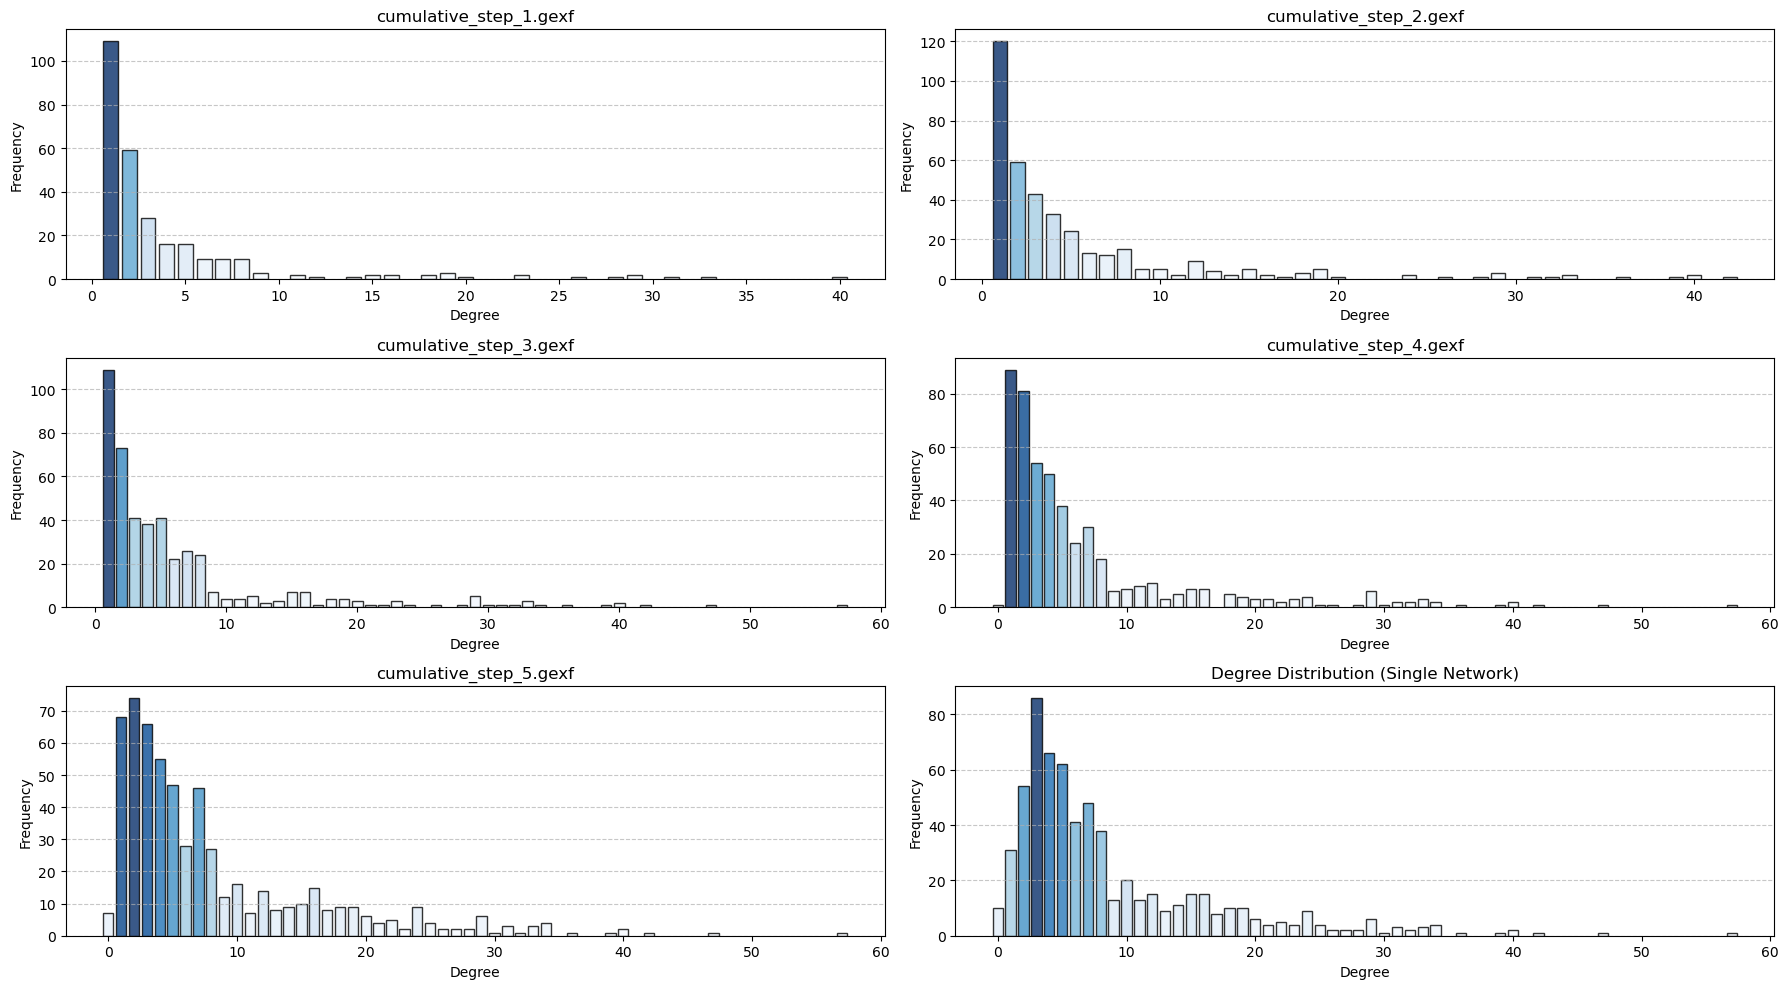

In [4]:
# File paths for cumulative networks
folder_path = '../networks/one_piece_cumulative/'
file_names = [
    'cumulative_step_1.gexf',
    'cumulative_step_2.gexf',
    'cumulative_step_3.gexf',
    'cumulative_step_4.gexf',
    'cumulative_step_5.gexf'
]
file_paths = [os.path.join(folder_path, file_name) for file_name in file_names]

# Single network file
single_file_path = '../networks/One_Piece.gexf'  # Replace with actual path

# Create a 2x3 grid layout for plots
fig, axes = plt.subplots(3, 2, figsize=(18, 10))
axes = axes.flatten()

# Process the cumulative networks
for ax, file_path in zip(axes[:5], file_paths):
    try:
        # Load the network
        G = nx.read_gexf(file_path)
        
        # Compute degree distribution
        degrees = [d for n, d in G.degree()]
        unique_degrees, counts = np.unique(degrees, return_counts=True)
        
        # Create color mapping
        norm = Normalize(vmin=min(counts), vmax=max(counts))
        cmap = plt.cm.Blues
        colors = [cmap(norm(count)) for count in counts]
        
        # Plot the degree distribution
        bars = ax.bar(unique_degrees, counts, color=colors, edgecolor='black', alpha=0.8)
        ax.set_title(os.path.basename(file_path))
        ax.set_xlabel("Degree")
        ax.set_ylabel("Frequency")
        ax.grid(axis='y', linestyle='--', alpha=0.7)
    except Exception as e:
        ax.set_title(f"Error: {os.path.basename(file_path)}")
        ax.text(0.5, 0.5, str(e), ha='center', va='center', fontsize=10)
        ax.axis('off')

# Process the single network file
try:
    G_single = nx.read_gexf(single_file_path)
    degrees = [d for n, d in G_single.degree()]
    unique_degrees, counts = np.unique(degrees, return_counts=True)
    
    # Create color mapping
    norm = Normalize(vmin=min(counts), vmax=max(counts))
    cmap = plt.cm.Blues
    colors = [cmap(norm(count)) for count in counts]
    
    # Plot the degree distribution for the single network
    ax = axes[5]
    bars = ax.bar(unique_degrees, counts, color=colors, edgecolor='black', alpha=0.8)
    ax.set_title("Degree Distribution (Single Network)")
    ax.set_xlabel("Degree")
    ax.set_ylabel("Frequency")
    ax.grid(axis='y', linestyle='--', alpha=0.7)
except Exception as e:
    ax = axes[5]
    ax.set_title("Error: Single Network")
    ax.text(0.5, 0.5, str(e), ha='center', va='center', fontsize=10)
    ax.axis('off')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


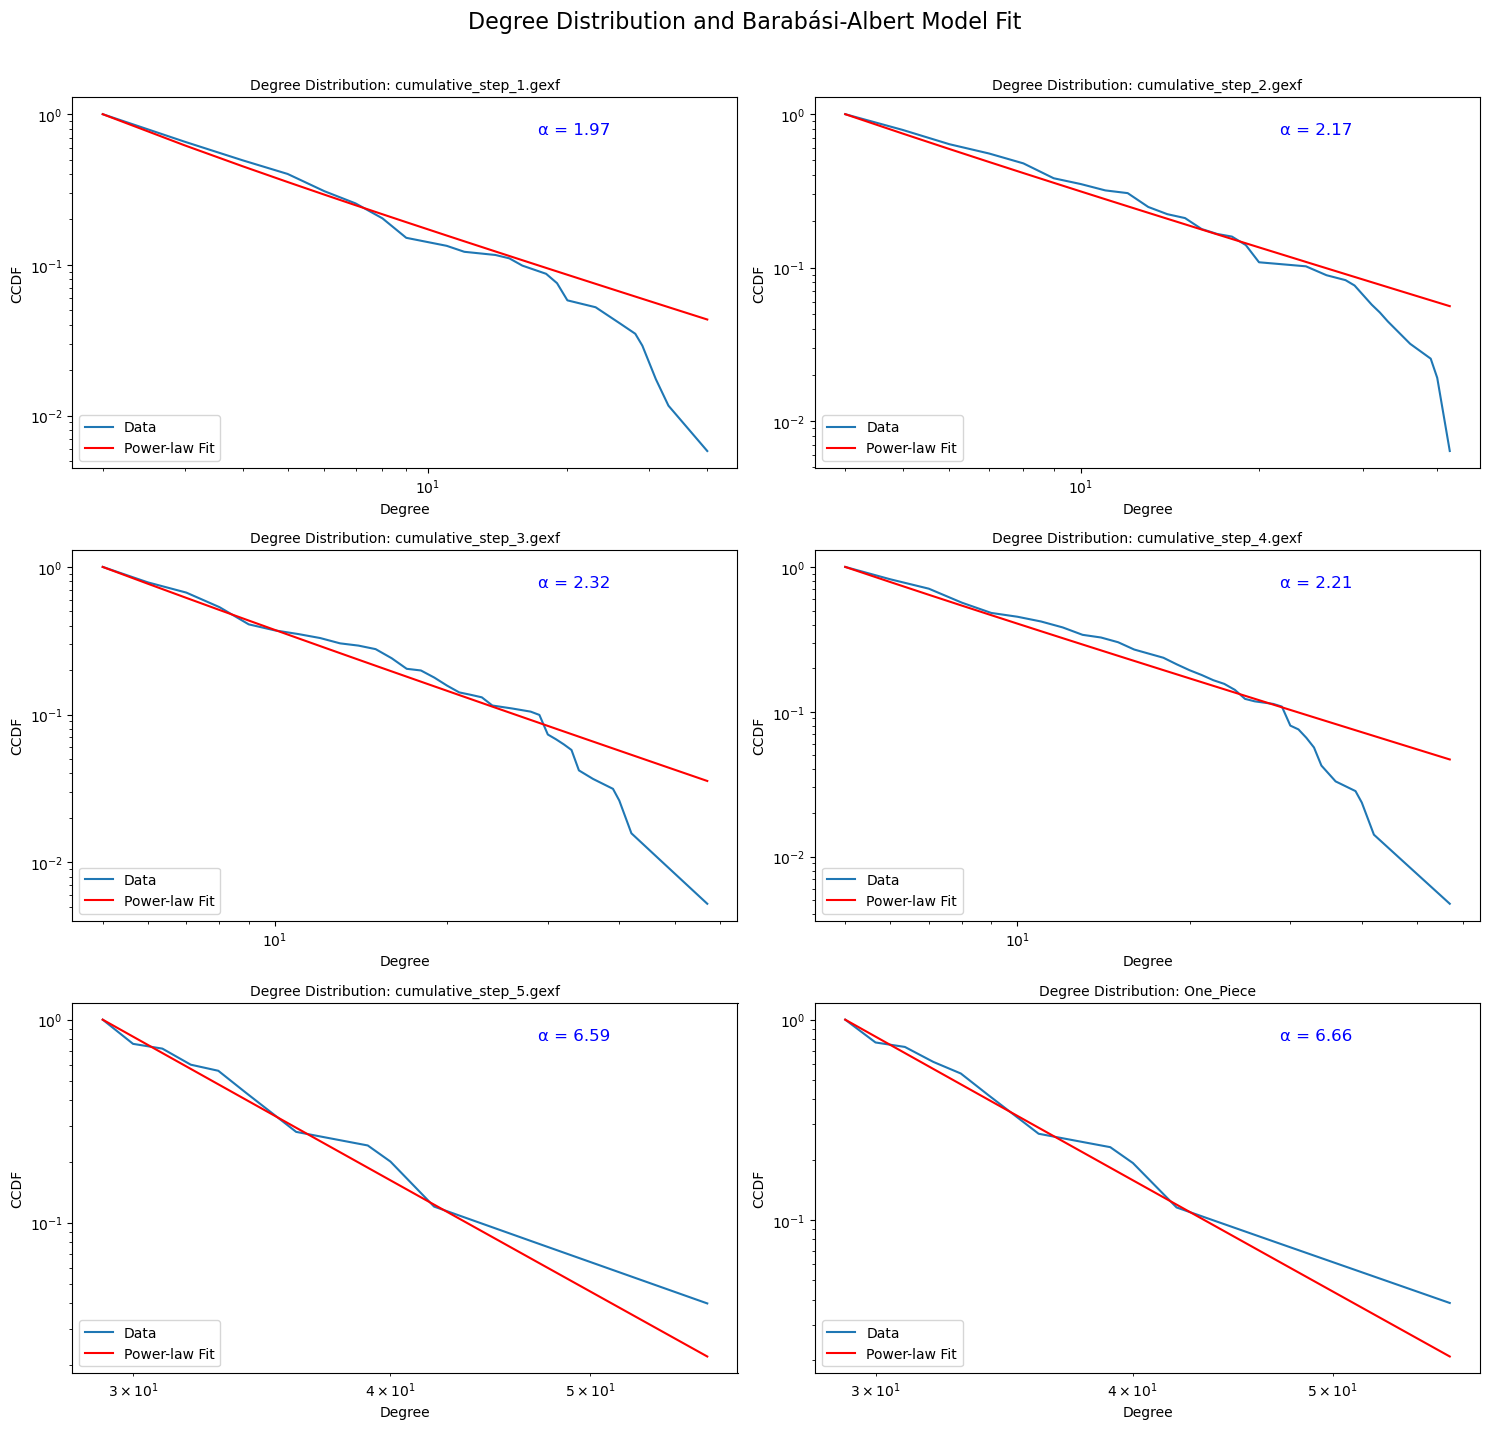

In [6]:
# Prepare for subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

def fit_and_plot(graph, graph_name, ax):
    degrees = [d for n, d in graph.degree()]
    with open(os.devnull, 'w') as fnull:
        sys.stdout = fnull
        results = powerlaw.Fit(degrees, discrete=True)
        sys.stdout = sys.__stdout__
    alpha = results.power_law.alpha
    results.plot_ccdf(label='Data', ax=ax)
    results.power_law.plot_ccdf(label='Power-law Fit', color='r', ax=ax)
    ax.legend()
    ax.set_title(f"Degree Distribution: {graph_name}", fontsize=10)
    ax.set_xlabel("Degree")
    ax.set_ylabel("CCDF")
    ax.annotate(f'α = {alpha:.2f}', xy=(0.7, 0.9), xycoords='axes fraction', fontsize=12, color='blue')

for i, (file_path, file_name) in enumerate(zip(file_paths + [single_file_path], file_names + ["One_Piece"])):
    if os.path.exists(file_path):
        graph = nx.read_gexf(file_path)
        fit_and_plot(graph, file_name, axes[i])

# Add a global title
plt.suptitle("Degree Distribution and Barabási-Albert Model Fit", fontsize=16, y=0.95)

# Adjust layout and show
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()